In [1]:
import torch 
torch.manual_seed(1)
import sys
sys.path.append('..')

from targets import Target
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

In [2]:
from models_nf import MixedModelDensityEstimator,DIFDensityEstimatorLayer,RealNVPDensityEstimatorLayer,DIFSamplerLayer, RealNVPSamplerLayer, MixedModelSampler

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
N = 256
orange = np.ones((N, 4))
orange[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
orange[:, 1] = np.geomspace(165 / 256, 1, N)  # G = 165
orange[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
orange_cmap = ListedColormap(orange[::-1])

orange_color = "#FFA500"

red = np.ones((N, 4))
red[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
red[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
red[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 0
red_cmap = ListedColormap(red[::-1])

red_color = "#FF0000"

blue = np.ones((N, 4))
blue[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
blue[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
blue[:, 2] = np.geomspace(255 / 256, 1, N)  # B = 255
blue_cmap = ListedColormap(blue[::-1])

blue_color = "#0000FF"

green = np.ones((N, 4))
green[:, 0] = np.geomspace(0.001 / 256, 1, N)  # R = 0
green[:, 1] = np.geomspace(128 / 256, 1, N)  # G = 128
green[:, 2] = np.geomspace(0.001 / 256, 1, N)  # B = 128
green_cmap = ListedColormap(green[::-1])

green_color = "#008000"

pink = np.ones((N, 4))
pink[:, 0] = np.geomspace(255 / 256, 1, N)  # R = 255
pink[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
pink[:, 2] = np.geomspace(211 / 256, 1, N)  # B = 211
pink_cmap = ListedColormap(pink[::-1])

pink_color = "#FF00D3"

purple = np.ones((N, 4))
purple[:, 0] = np.geomspace(51 / 256, 1, N)  # R = 102
purple[:, 1] = np.geomspace(0.001 / 256, 1, N)  # G = 0
purple[:, 2] = np.geomspace(51 / 256, 1, N)  # B = 102
purple_cmap = ListedColormap(purple[::-1])

purple_color = "#660066"

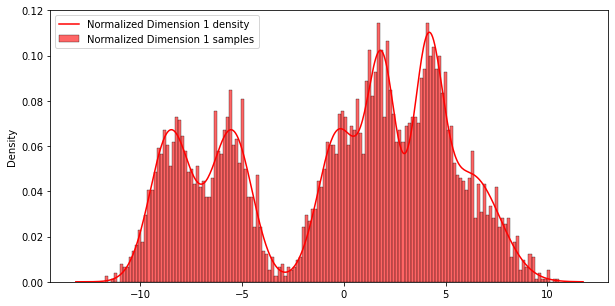

In [4]:
example =  "Normalized Dimension 1"
num_samples = 50000
target =Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [5]:
num_samples = target_samples.shape[0]
batch_size = 5000
epochs =100
structure = [[DIFSamplerLayer,2],[DIFSamplerLayer,2],[DIFSamplerLayer,2]]
flow = MixedModelSampler(target_log_density,p,structure)
flow.train(num_samples, epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:21<00:00,  8.01s/it, loss = 1.424608]


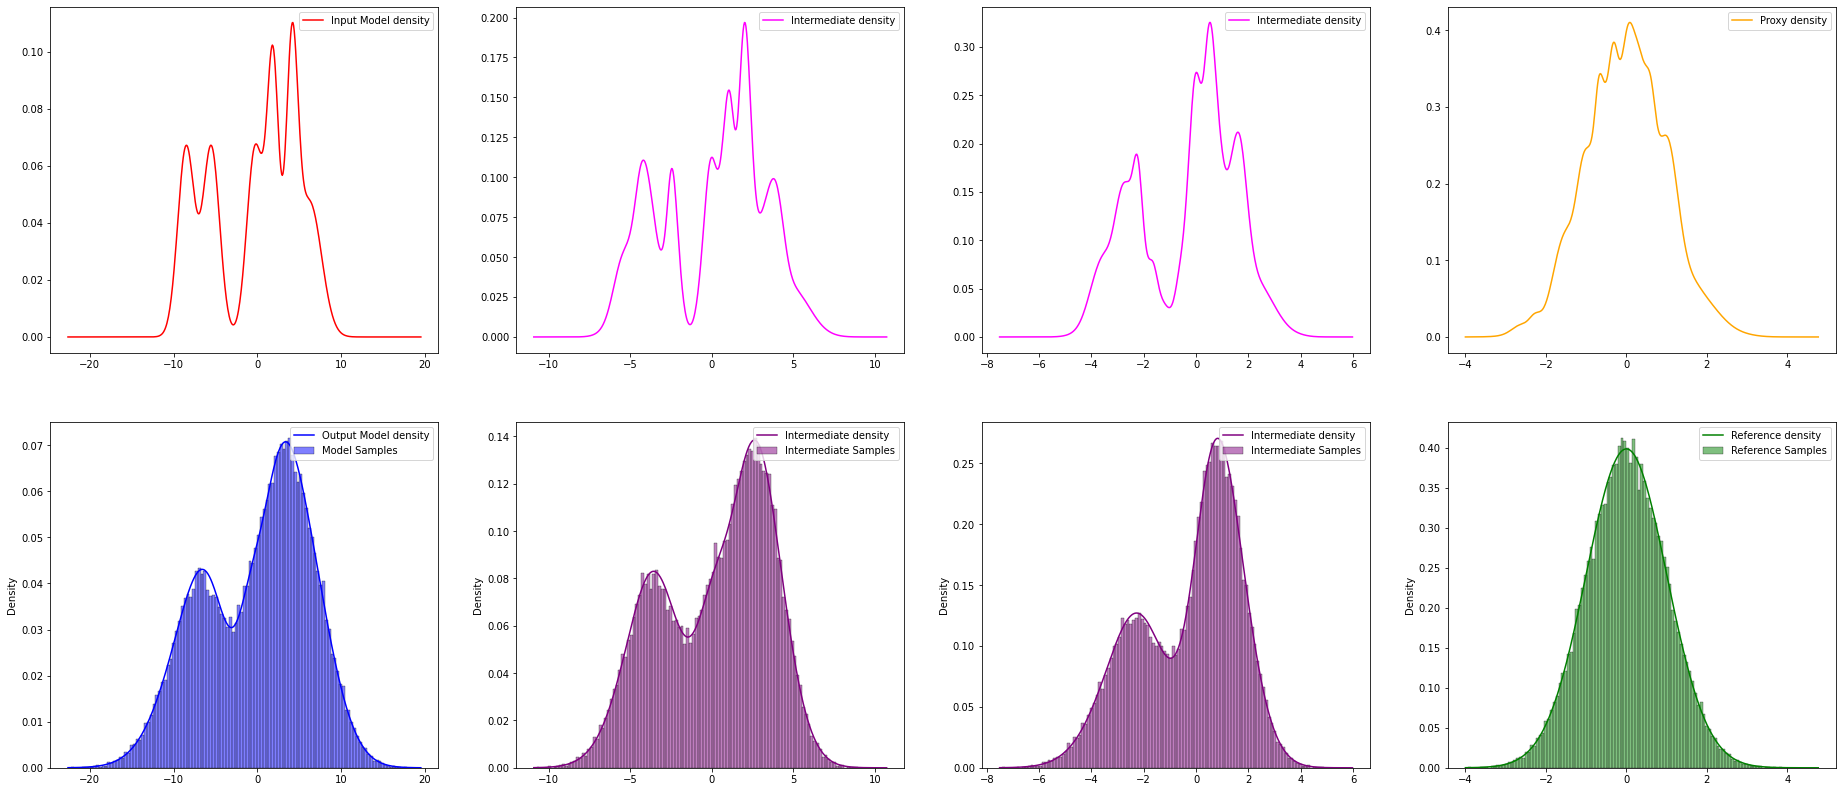

In [6]:
### Visualize sampler flow dimension 1###

linspace = 500
with torch.no_grad():
    samples = flow.reference.sample(num_samples)
    backward_samples = [samples]
    tt = torch.linspace(torch.min(backward_samples[0]), torch.max(backward_samples[0]), linspace).unsqueeze(1)
    backward_density = [torch.exp(flow.model[-1].q_log_density(tt))]
    backward_linspace = [tt]
    forward_density = [torch.exp(flow.model[-1].log_phi(tt))]
    for i in range(flow.N - 1, -1, -1):
        samples = flow.model[i].sample_backward(samples)
        tt = torch.linspace(torch.min(samples), torch.max(samples),linspace).unsqueeze(1)
        b_density = torch.exp(flow.model[i].log_psi(tt))
        f_density = torch.exp(flow.model[i].p_log_density(tt))
        backward_samples.insert(0, samples)
        backward_linspace.insert(0, tt)
        backward_density.insert(0,b_density)
        forward_density.insert(0,f_density)

fig = plt.figure(figsize=((flow.N+1)*8, 2*7))
ax = fig.add_subplot(2,flow.N+1,1)
ax.plot(backward_linspace[0].cpu(), forward_density[0].cpu(), color='red',
        label="Input Model density")
ax.legend(loc = 1)
for i in range(1, flow.N):
    ax = fig.add_subplot(2, flow.N + 1, i+1)
    ax.plot(backward_linspace[i].cpu(), forward_density[i].cpu(), color='magenta',
            label="Intermediate density")
    ax.legend(loc = 1)
ax = fig.add_subplot(2, flow.N + 1, flow.N+1)
ax.plot(backward_linspace[-1].cpu(), forward_density[-1].cpu(), color='orange',
        label="Proxy density")
ax.legend(loc = 1)
ax = fig.add_subplot(2,flow.N+1,flow.N+1+1)
sns.histplot(backward_samples[0][:,0].cpu(),  stat="density", alpha=0.5, bins=125, color='blue',label="Model Samples")
ax.plot(backward_linspace[0].cpu(), backward_density[0].cpu(), color='blue',
        label="Output Model density")
ax.legend(loc = 1)
for i in range(1, flow.N):
    ax = fig.add_subplot(2, flow.N + 1, flow.N+1 + i+1)
    sns.histplot(backward_samples[i][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color='purple',label="Intermediate Samples")
    ax.plot(backward_linspace[i].cpu(), backward_density[i].cpu(), color='purple',
            label="Intermediate density")
    ax.legend(loc = 1)
ax = fig.add_subplot(2, flow.N + 1, flow.N+1 + flow.N+1)
ax.plot(backward_linspace[-1].cpu(), backward_density[-1].cpu(), color='green', label="Reference density")
sns.histplot(backward_samples[-1][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color='green',
             label="Reference Samples")
ax.legend(loc = 1)

In [7]:
num_samples = target_samples.shape[0]
epochs =100
structure = [[DIFDensityEstimatorLayer,2],[DIFDensityEstimatorLayer,2],[DIFDensityEstimatorLayer,2]]
dif = MixedModelDensityEstimator(target_samples,structure)
dif.train(epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it, loss = 3.422574]


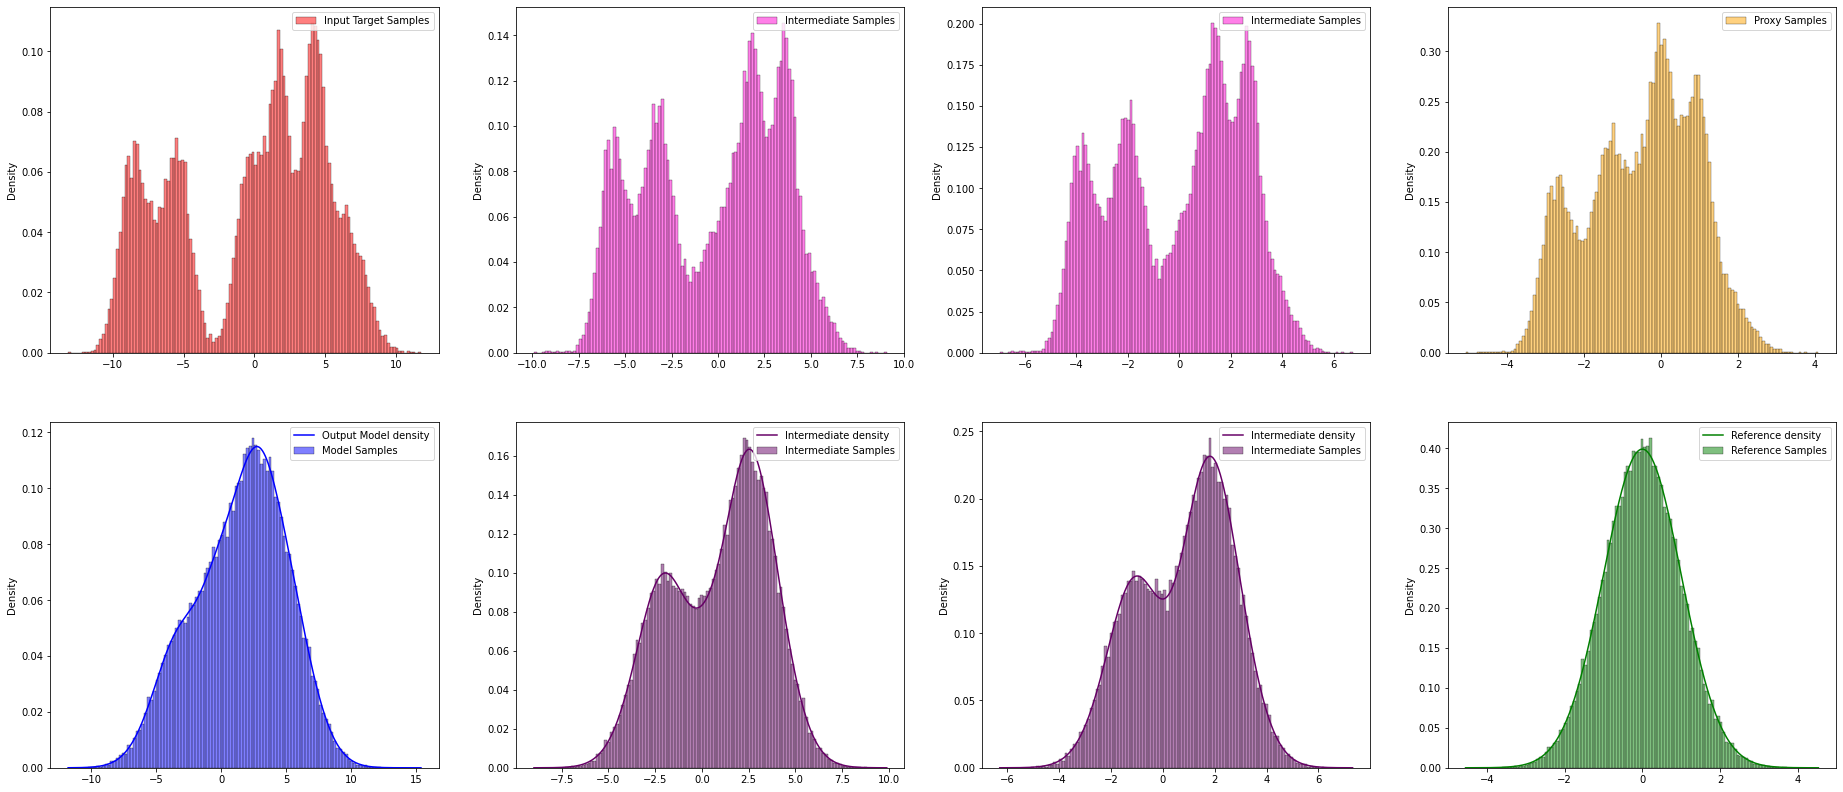

In [8]:
###Visualize Flow model dimension 1###

import seaborn as sns
linspace = 500
with torch.no_grad():
    backward_samples = [dif.reference.sample(num_samples)]
    tt = torch.linspace(torch.min(backward_samples[0]), torch.max(backward_samples[0]), linspace).unsqueeze(
        1)
    backward_density = [torch.exp(dif.reference.log_density(tt))]
    backward_linspace = [tt]
    for i in range(dif.N - 1, -1, -1):
        samples = dif.model[i].sample_backward(backward_samples[0])
        tt = torch.linspace(torch.min(samples), torch.max(samples), linspace).unsqueeze(1)
        density = torch.exp(dif.model[i].log_psi(tt))
        backward_samples.insert(0, samples)
        backward_linspace.insert(0, tt)
        backward_density.insert(0, density)

with torch.no_grad():
    forward_samples = [dif.target_samples[:num_samples]]
    for i in range(dif.N):
        forward_samples.append(dif.model[i].sample_forward(forward_samples[-1]))

fig = plt.figure(figsize=((dif.N + 1) * 8, 2 * 7))
ax = fig.add_subplot(2, dif.N + 1, 1)
sns.histplot(forward_samples[0][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=red_color,
             label="Input Target Samples")
ax.legend(loc=1)
for i in range(1, dif.N):
    ax = fig.add_subplot(2, dif.N + 1, i + 1)
    sns.histplot(forward_samples[i][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=pink_color,
                 label="Intermediate Samples")
    ax.legend(loc=1)
ax = fig.add_subplot(2, dif.N + 1, dif.N + 1)
sns.histplot(forward_samples[-1][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=orange_color,
             label="Proxy Samples")
ax.legend(loc=1)

ax = fig.add_subplot(2, dif.N + 1, dif.N + 1 + 1)
sns.histplot(backward_samples[0][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=blue_color,
             label="Model Samples")
ax.plot(backward_linspace[0].cpu(), backward_density[0].cpu(), color=blue_color,
        label="Output Model density")
ax.legend(loc=1)
for i in range(1, dif.N):
    ax = fig.add_subplot(2, dif.N + 1, dif.N + 1 + i + 1)
    sns.histplot(backward_samples[i][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=purple_color,
                 label="Intermediate Samples")
    ax.plot(backward_linspace[i].cpu(), backward_density[i].cpu(), color=purple_color,
            label="Intermediate density")
    ax.legend(loc=1)
ax = fig.add_subplot(2, dif.N + 1, dif.N + 1 + dif.N + 1)
ax.plot(backward_linspace[-1].cpu(), backward_density[-1].cpu(), color='green', label="Reference density")
sns.histplot(backward_samples[-1][:, 0].cpu(), stat="density", alpha=0.5, bins=125, color=green_color,
             label="Reference Samples")
ax.legend(loc=1)

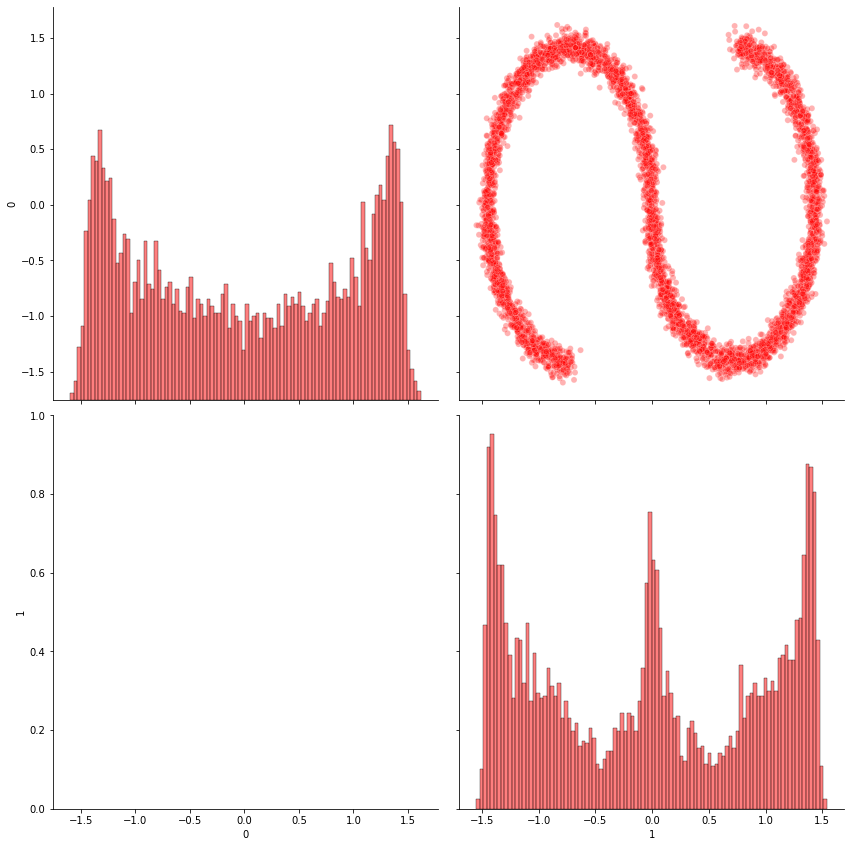

In [9]:
example =  "S Curve"
num_samples = 50000
target =Target(example, num_samples)
target.target_visual()
p, target_log_density, target_samples = target.get_target()

In [10]:
num_samples = target_samples.shape[0]
epochs =100
structure = [[RealNVPDensityEstimatorLayer,[64,64,64]],[RealNVPDensityEstimatorLayer,[64,64,64]],[RealNVPDensityEstimatorLayer,[64,64,64]]]
realnvp = MixedModelDensityEstimator(target_samples,structure)
realnvp.train(epochs, batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.17s/it, loss = 0.844992]


c:\users\ea264728\pycharmprojects\normalizing_flows\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


Text(0.5, 1.0, '$Q$ Density')

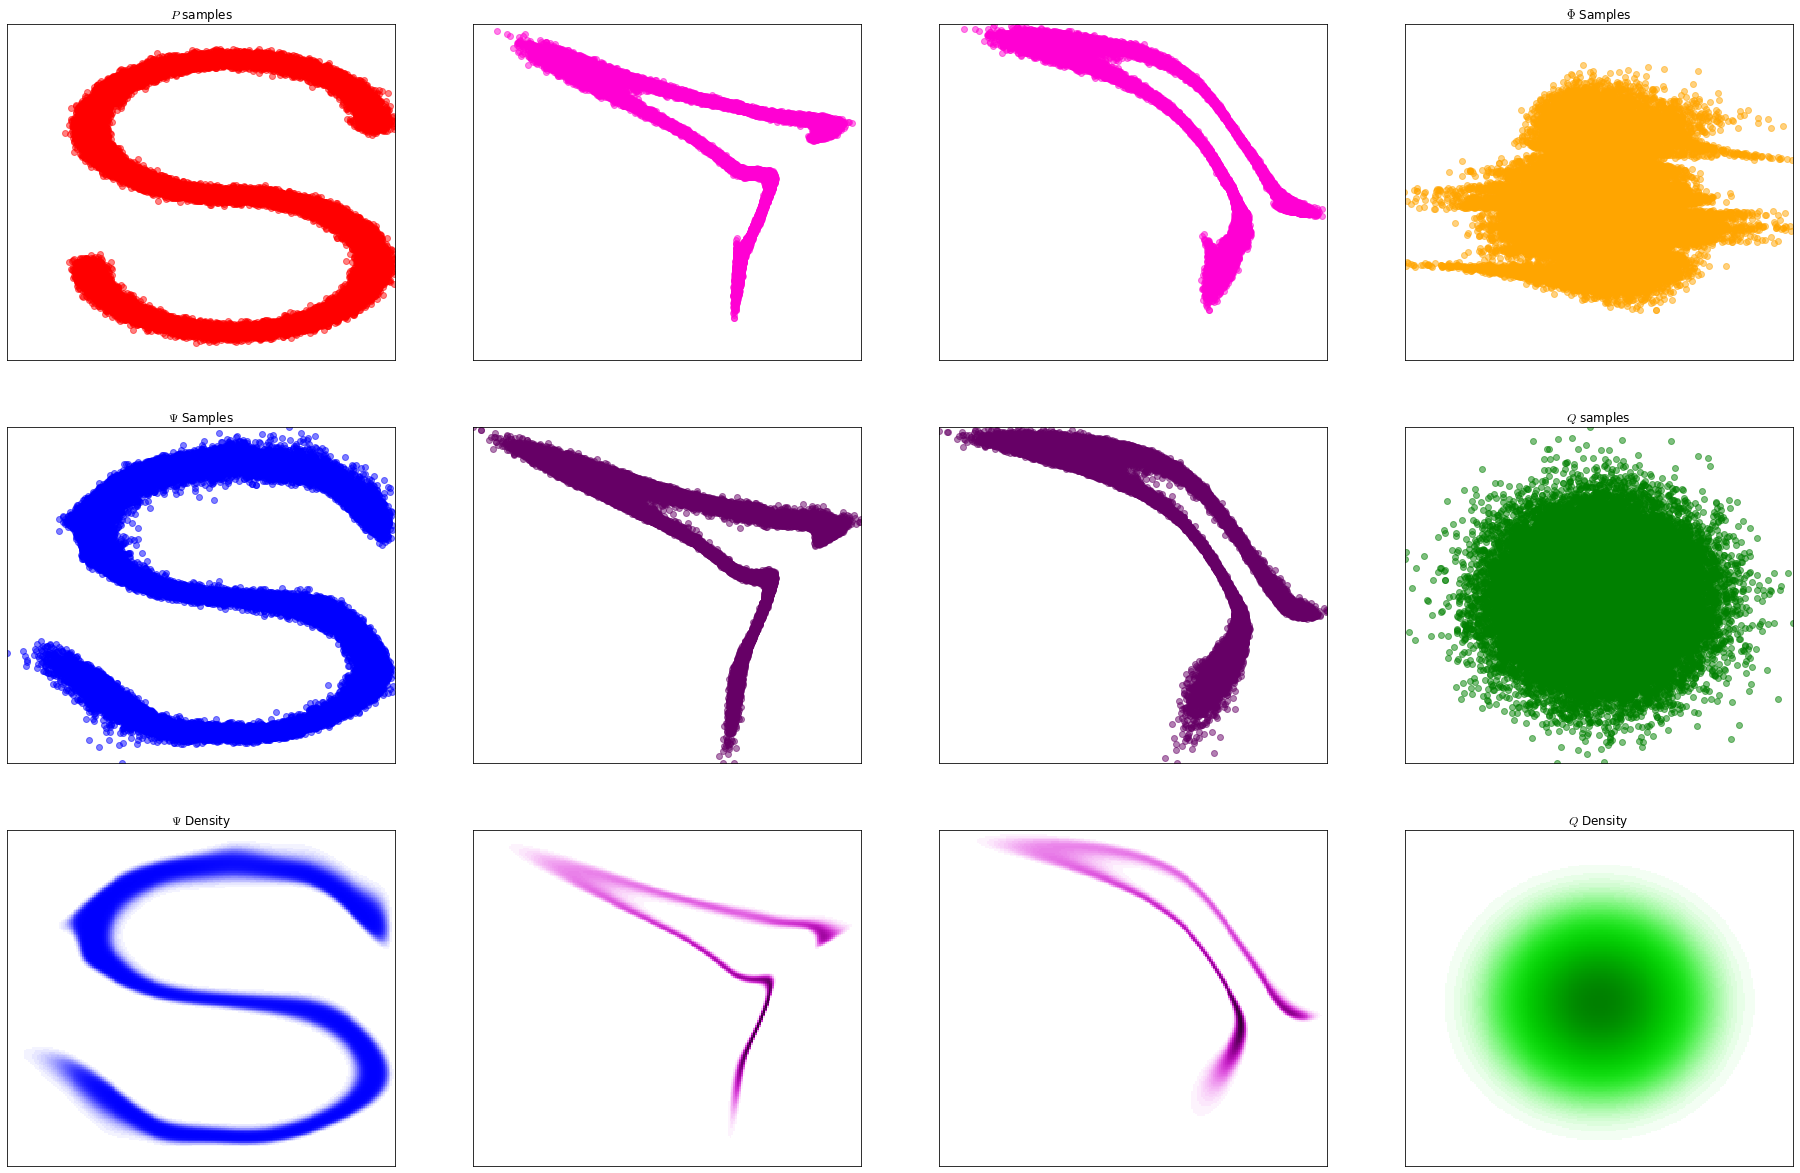

In [11]:
###Visualize Density Estimation Flow dimension >1###

delta = 200
with torch.no_grad():
    samples = realnvp.reference.sample(num_samples)
    backward_samples = [samples]
    grid = torch.cartesian_prod(torch.linspace(torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item(),delta),torch.linspace(torch.min(samples[:,1]).item(), torch.max(samples[:,1]).item(),delta))
    grid = torch.cat((grid, torch.mean(samples[:,2:], dim = 0)*torch.ones(grid.shape[0], realnvp.p-2)), dim = -1)
    density = torch.exp(realnvp.reference.log_density(grid)).reshape(delta,delta).T.cpu().detach()
    backward_density = [density]
    x_range = [[torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item()]]
    y_range = [[torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item()]]
    for i in range(realnvp.N - 1, -1, -1):
        samples = realnvp.model[i].sample_backward(backward_samples[0])
        backward_samples.insert(0, samples)
        grid = torch.cartesian_prod(torch.linspace(torch.min(samples[:, 0]).item(), torch.max(samples[:, 0]).item(), delta),torch.linspace(torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item(), delta))
        grid = torch.cat((grid, torch.zeros(grid.shape[0], realnvp.p - 2)), dim=-1)
        density = torch.exp(realnvp.model[i].log_psi(grid)).reshape(delta, delta).T.cpu().detach()
        backward_density.insert(0, density)
        x_range.insert(0,[torch.min(samples[:,0]).item(), torch.max(samples[:,0]).item()])
        y_range.insert(0,[torch.min(samples[:, 1]).item(), torch.max(samples[:, 1]).item()])

with torch.no_grad():
    forward_samples = [realnvp.target_samples[:num_samples]]
    for i in range(realnvp.N):
        forward_samples.append(realnvp.model[i].sample_forward(forward_samples[-1]))

fig = plt.figure(figsize=((realnvp.N + 1) * 8, 3 * 7))
ax = fig.add_subplot(3, realnvp.N + 1, 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(forward_samples[0][:, 0].cpu(), forward_samples[0][:, 1].cpu(), alpha=0.5, color=red_color)
ax.set_title(r'$P$ samples')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
for i in range(1, realnvp.N):
    ax = fig.add_subplot(3, realnvp.N + 1, i + 1)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.scatter(forward_samples[i][:, 0].cpu(), forward_samples[i][:, 1].cpu(), alpha=0.5,
                color=pink_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
ax = fig.add_subplot(3, realnvp.N + 1, realnvp.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(forward_samples[-1][:, 0].cpu(), forward_samples[-1][:, 1].cpu(), alpha=0.5,
            color=orange_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$\Phi$ Samples')

ax = fig.add_subplot(3, realnvp.N + 1, realnvp.N + 1 + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(backward_samples[0][:, 0].cpu(), backward_samples[0][:, 1].cpu(), alpha=0.5, color=blue_color)
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Samples')
ax = fig.add_subplot(3, realnvp.N + 1, 2*(realnvp.N + 1) + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item(), 200), backward_density[0],cmap = blue_cmap,shading='auto' )
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Density')
for i in range(1, realnvp.N):
    ax = fig.add_subplot(3, realnvp.N + 1, realnvp.N + 1 + i + 1)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.scatter(backward_samples[i][:, 0].cpu(), backward_samples[i][:, 1].cpu(), alpha=0.5,
                color=purple_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax = fig.add_subplot(3, realnvp.N + 1, 2 * (realnvp.N + 1) + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(), torch.max(backward_samples[i][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[i][:, 1]).item(), torch.max(backward_samples[i][:, 1]).item(), 200), backward_density[i], cmap=purple_cmap,shading='auto')

ax = fig.add_subplot(3, realnvp.N + 1, realnvp.N + 1 + realnvp.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(backward_samples[-1][:, 0].cpu(), backward_samples[-1][:, 1].cpu(), alpha=0.5,
            color=green_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ samples')
ax = fig.add_subplot(3, realnvp.N + 1, 2*(realnvp.N + 1) + realnvp.N + 1)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(), torch.max(backward_samples[-1][:, 0]).item(), 200),torch.linspace(torch.min(backward_samples[-1][:, 1]).item(), torch.max(backward_samples[-1][:, 1]).item(), 200), backward_density[-1], cmap=green_cmap,shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r"$Q$ Density")

In [12]:
target_log_density = realnvp.log_density
num_samples = target_samples.shape[0]
epochs =100
batch_size = int(num_samples/50)
structure = [[RealNVPSamplerLayer,[64,64,64]],[RealNVPSamplerLayer,[64,64,64]],[RealNVPSamplerLayer,[64,64,64]],[RealNVPSamplerLayer,[64,64,64]]]
flow = MixedModelSampler(target_log_density,2,structure)
flow.train(num_samples,epochs,batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:05<00:00,  3.05s/it, loss = 326621.90625]


Text(0.5, 1.0, '$Q$ Density')

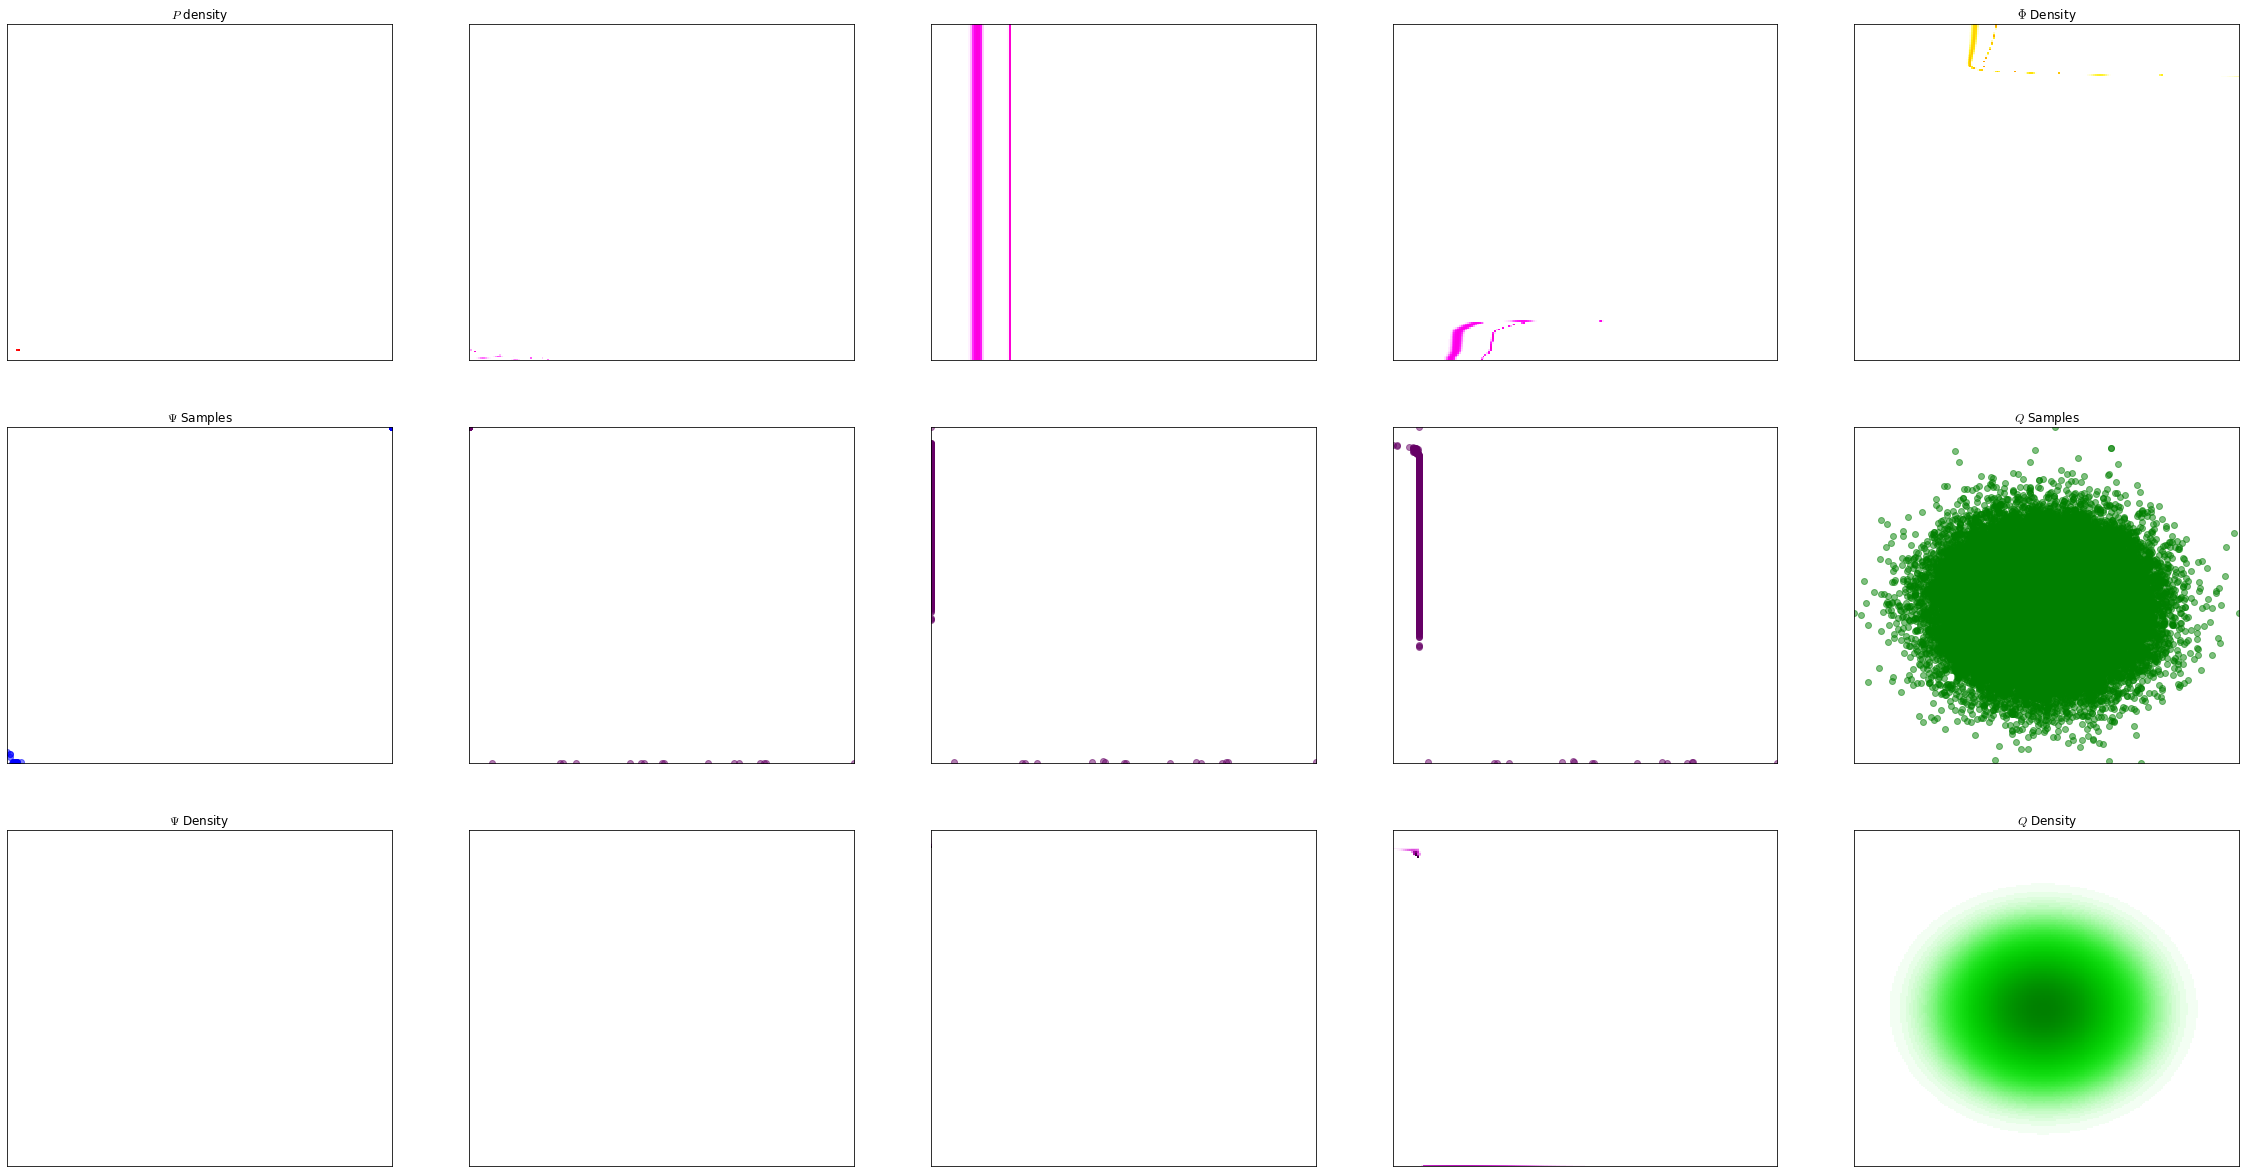

In [13]:
delta = 200
with torch.no_grad():
    backward_samples = [flow.reference.sample(num_samples)]
    grid = torch.cat((torch.cartesian_prod(
        torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                       torch.max(backward_samples[0][:, 0]).item(), delta),
        torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                       torch.max(backward_samples[0][:, 1]).item(), delta)),
                      torch.mean(backward_samples[0][:, 2:], dim=0) * torch.ones(delta**2,flow.p - 2)),dim=-1)
    backward_density = [torch.exp(flow.reference.log_density(grid)).reshape(delta, delta).T.cpu().detach()]
    forward_density = [torch.exp(flow.model[-1].log_phi(grid)).reshape(delta, delta).T.cpu().detach()]
    x_range = [[torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item()]]
    y_range = [[torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item()]]
    for i in range(flow.N - 1, -1, -1):
        backward_samples.insert(0, flow.model[i].sample_backward(backward_samples[0]))
        grid = torch.cat((torch.cartesian_prod(
            torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                           torch.max(backward_samples[0][:, 0]).item(), delta),
            torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                           torch.max(backward_samples[0][:, 1]).item(), delta)),
                          torch.mean(backward_samples[0][:, 2:], dim=0) * torch.ones(delta**2,flow.p - 2)), dim=-1)
        backward_density.insert(0, torch.exp(flow.model[i].log_psi(grid)).reshape(delta,
                                                                                        delta).T.cpu().detach())
        forward_density.insert(0, torch.exp(flow.model[i].p_log_density(grid)).reshape(delta,
                                                                                       delta).T.cpu().detach())
        x_range.insert(0, [torch.min(backward_samples[0][:, 0]).item(), torch.max(backward_samples[0][:, 0]).item()])
        y_range.insert(0, [torch.min(backward_samples[0][:, 1]).item(), torch.max(backward_samples[0][:, 1]).item()])

fig = plt.figure(figsize=((flow.N + 1) * 8, 3 * 7))
ax = fig.add_subplot(3, flow.N + 1, 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                             torch.max(backward_samples[0][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                             torch.max(backward_samples[0][:, 1]).item(), delta), forward_density[0],
              cmap=red_cmap, shading='auto')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$P$ density')
for i in range(1, flow.N):
    ax = fig.add_subplot(3, flow.N + 1, i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(),
                                 torch.max(backward_samples[i][:, 0]).item(), delta),
                  torch.linspace(torch.min(backward_samples[i][:, 1]).item(),
                                 torch.max(backward_samples[i][:, 1]).item(), delta), forward_density[i],
                  cmap=pink_cmap, shading='auto')
ax = fig.add_subplot(3, flow.N + 1, flow.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(),
                             torch.max(backward_samples[-1][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[-1][:, 1]).item(),
                             torch.max(backward_samples[-1][:, 1]).item(), delta), forward_density[-1],
              cmap=orange_cmap, shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$\Phi$ Density')

ax = fig.add_subplot(3, flow.N + 1, flow.N + 1 + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(backward_samples[0][:, 0].cpu(), backward_samples[0][:, 1].cpu(), alpha=0.5, color=blue_color)
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Samples')
ax = fig.add_subplot(3, flow.N + 1, 2 * (flow.N + 1) + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[0][:, 0]).item(),
                             torch.max(backward_samples[0][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[0][:, 1]).item(),
                             torch.max(backward_samples[0][:, 1]).item(), delta), backward_density[0],
              cmap=blue_cmap, shading='auto')
ax.set_xlim((x_range[0][0], x_range[0][1]))
ax.set_ylim((y_range[0][0], y_range[0][1]))
ax.set_title(r'$\Psi$ Density')
for i in range(1, flow.N):
    ax = fig.add_subplot(3, flow.N + 1, flow.N + 1 + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.scatter(backward_samples[i][:, 0].cpu(), backward_samples[i][:, 1].cpu(), alpha=0.5,
               color=purple_color)
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
    ax = fig.add_subplot(3, flow.N + 1, 2 * (flow.N + 1) + i + 1)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.pcolormesh(torch.linspace(torch.min(backward_samples[i][:, 0]).item(),
                                 torch.max(backward_samples[i][:, 0]).item(), delta),
                  torch.linspace(torch.min(backward_samples[i][:, 1]).item(),
                                 torch.max(backward_samples[i][:, 1]).item(), delta), backward_density[i],
                  cmap=purple_cmap, shading='auto')
    ax.set_xlim((x_range[i][0], x_range[i][1]))
    ax.set_ylim((y_range[i][0], y_range[i][1]))
ax = fig.add_subplot(3, flow.N + 1, flow.N + 1 + flow.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(backward_samples[-1][:, 0].cpu(), backward_samples[-1][:, 1].cpu(), alpha=0.5,
           color=green_color)
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ Samples')
ax = fig.add_subplot(3, flow.N + 1, 2 * (flow.N + 1) + flow.N + 1)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.pcolormesh(torch.linspace(torch.min(backward_samples[-1][:, 0]).item(),
                             torch.max(backward_samples[-1][:, 0]).item(), delta),
              torch.linspace(torch.min(backward_samples[-1][:, 1]).item(),
                             torch.max(backward_samples[-1][:, 1]).item(), delta), backward_density[-1],
              cmap=green_cmap, shading='auto')
ax.set_xlim((x_range[-1][0], x_range[-1][1]))
ax.set_ylim((y_range[-1][0], y_range[-1][1]))
ax.set_title(r'$Q$ Density')